In [1]:
from kbmodpy import kbmod as kb
from trajectoryFiltering import *
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = '../../HITS/test_35/4,6tempExp/new_header/'

In [3]:
files = os.listdir(path)

In [4]:
files.sort()
files = [path+f for f in files]
files = files[:4]
files

['../../HITS/test_35/4,6tempExp/new_header/v410913-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v410969-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411019-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411053-fg.fits']

In [5]:
images = [kb.layered_image(f) for f in files]

In [6]:
p = kb.psf(1.4)

In [7]:
object_count = 250
x_range = (5,3650)
y_range = (5, 3650)
xv_range = (2100,2450)
yv_range = (800,1100)
angle_range = tuple( math.atan(yv/xv) for xv,yv in zip(xv_range, yv_range))
velocity_range = tuple( math.sqrt(xv**2+yv**2) for xv,yv in zip(xv_range, yv_range))
flux_range = (500, 2500)

In [8]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    traj.x_v = rd.uniform(*xv_range)
    traj.y_v = rd.uniform(*yv_range)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

In [9]:
if path == '../../HITS/test_35/4,6tempExp/new_header/':
    real_result = kb.trajectory()
    real_result.flux = 5300
    real_result.x = 3124
    real_result.y = 3043
    real_result.x_v = 2425
    real_result.y_v = 1050
    results_key.append(real_result)
results_key[0]

lh: 0.000000 flux: 1280.395142 x: 2188 y: 764 x_v: 2108.389404 y_v: 1059.297974 obs_count: 0

In [10]:
len(cluster_trajectories(results_key, dbscan_args=dict(eps=0.007, min_samples=1))[1])

251

In [11]:
for t in results_key:
    add_trajectory(images, t, p)

In [12]:
len(match_trajectories(results_key, results_key, 0.01, 1))

251

In [13]:
stack = kb.image_stack(images)

In [14]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [15]:
stack.apply_mask_flags(flags, flag_exceptions)

In [16]:
stack.apply_master_mask(master_flags, 2)

In [84]:
images = [i.science() for i in stack.get_images()]

In [95]:
img = images[1] #kb.layered_image("test",4096, 4096, 20.0, 400.0, 0.0)#

In [86]:
percent_masked = img[np.where(img==-9999.99)].size/img.size
percent_masked

0.15934744897959183

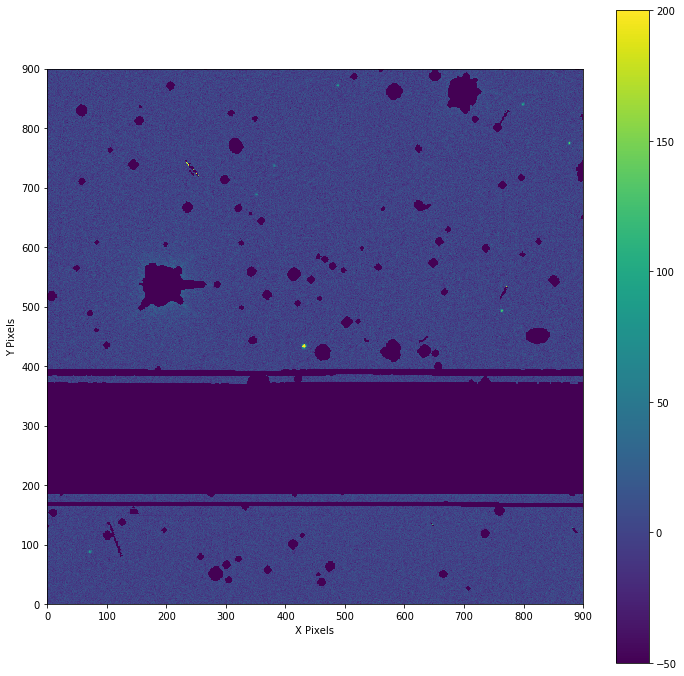

In [96]:
fig = plt.figure(figsize=(12,12))
plt.imshow(img[2700:3600,2900:3800], origin='lower',  vmin=-50, vmax=200)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [22]:
search = kb.stack_search(stack, p)

In [23]:
search.gpu(80,80, *angle_range, *velocity_range)

In [24]:
min_observations = 3
search.filter_min_obs(min_observations)

In [53]:
results = search.get_results(0, 1500000)

In [54]:
#results = [t for t in results if t.obs_count>=2]

In [56]:
len(results)

1500000

In [55]:
results_clustered = [ results[i] 
    for i in cluster_trajectories(results, dbscan_args=dict(eps=0.0055, min_samples=1))[1] ]

In [57]:
#search.save_results("filtered.txt", 0.03)

In [58]:
len(results_clustered)

329014

In [59]:
#results_clustered

In [60]:
#results_key

In [61]:
maximum_expected_detections(stack.img_count(), min_observations, percent_masked, len(results_key))

220.3992966254924

In [62]:
results_matched = match_trajectories(results_clustered, results_key, 0.01, 1)
print(len(results_matched))
#matched_trajectories

136


In [63]:
results_to_plot = results_matched
                  #results
                  #results_clustered 
                  #results_matched 
                  #results_key  


In [64]:
stamps = [create_postage_stamp(images, t, stack.get_times(), [31,31])[0] for t in results_to_plot]

Starting at 0


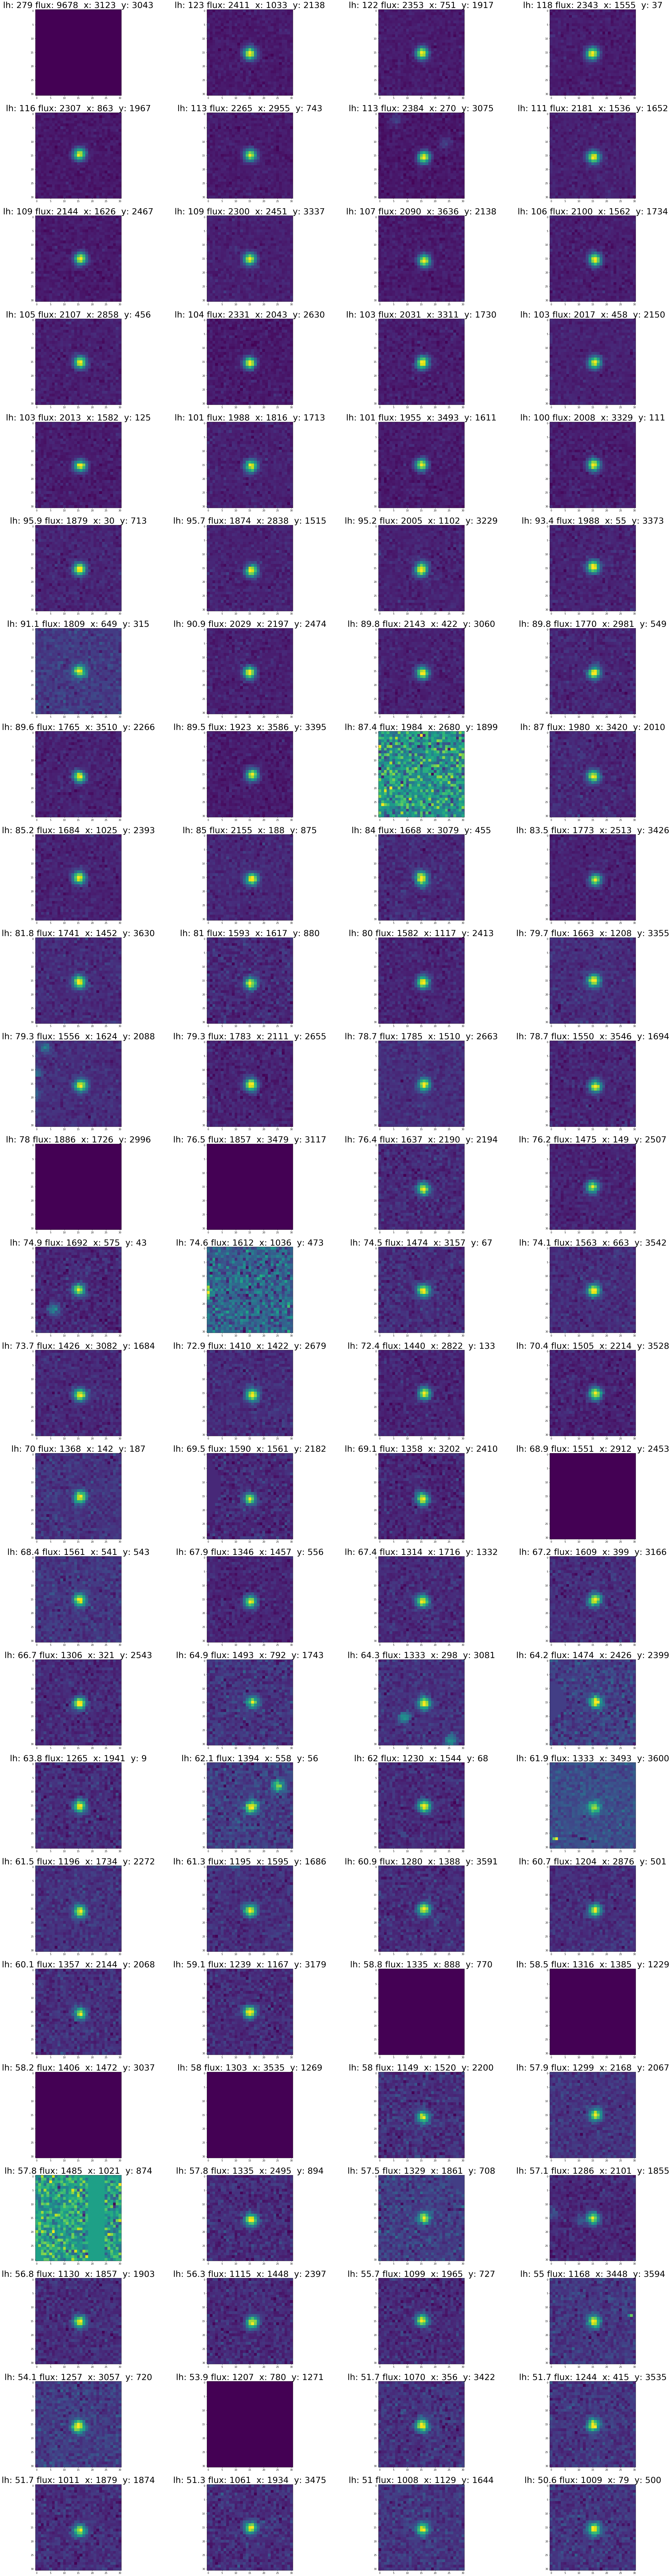

In [100]:
fig = plt.figure(figsize=(50, 200))
set_on = 1
plot_count = min(100,len(stamps))
print ('Starting at %i' % int((set_on - 1)*plot_count))
for i in range((set_on-1)*plot_count,set_on*plot_count):
    fig.add_subplot(25,4,i-(set_on-1)*plot_count+1)
    plt.imshow(stamps[i], #cmap=plt.cm.Greys_r, 
               interpolation=None)
    rplt=results_to_plot[i]
    plt.title('lh: {0:.3g} flux: {1:.4g}  x: {2}  y: {3}'.format(rplt.lh, rplt.flux, rplt.x, rplt.y) , fontsize=36)
    #plt.colorbar()

In [66]:
def plot_histogram(results_to_plt, bins, x_rng, y_rng, name, title, color):
# the histogram of the data
    n, bins, patches = plt.hist(np.array(results_to_plt), bins, normed=0, facecolor=color, alpha=0.75)

    # add a 'best fit' line
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=1)

    plt.xlabel(name)
    plt.ylabel('Detections')
    plt.title(title)
    plt.axis([*x_rng, *y_rng])
    plt.grid(True)

    plt.show()

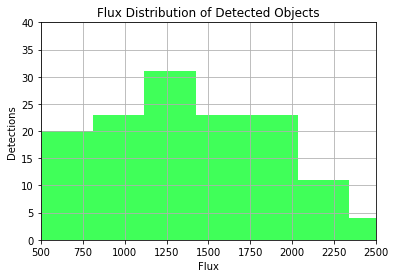

In [107]:
plot_histogram([t.flux for t in results_to_plot], 30, 
flux_range, (0,40), 'Flux', 'Flux Distribution of Detected Objects', '#00ff22')

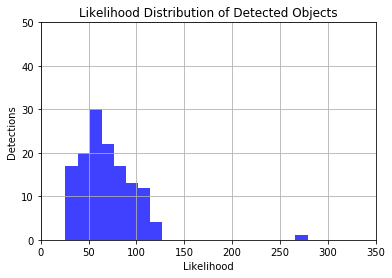

In [68]:
plot_histogram([t.lh for t in results_to_plot], 20, 
(0, 350), (0,50), 'Likelihood', 'Likelihood Distribution of Detected Objects', 'blue')

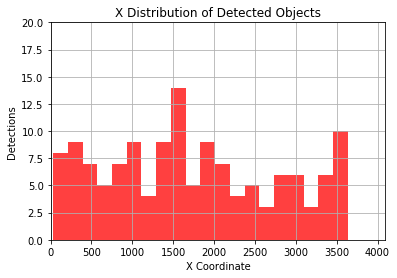

In [97]:
plot_histogram([t.x for t in results_to_plot], 20,
(0, 4096), (0,20), 'X Coordinate', 'X Distribution of Detected Objects', 'red')

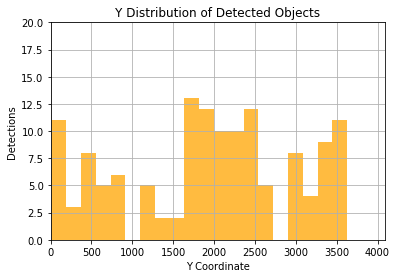

In [98]:
plot_histogram([t.y for t in results_to_plot], 20, 
(0, 4096), (0,20), 'Y Coordinate', 'Y Distribution of Detected Objects', 'orange')